# Coursework 1

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mode
import seaborn as sns
import random

## Task 1: Regression

## Question 1.1

### Question 1.1.1

We will be creating a linear regression model to predict the median value of owner-occupieed homes in USD 1000's. 

We know we are solving a problem of the form $$y = x^{T}\beta + \epsilon, \quad \epsilon \sim N(0,\sigma ^{2}).$$

Our data set has been provided in a useful format: we consider the first $18$ columns of the set as our $X$ and the final as our $Y$. From lectures, we know that our aim is to solve $$ \min_{\beta} \|Y - X \beta \|^2 = \min_{\beta} \text{L}_{\text{LS}}(\beta)$$ where $\text{L}_{\text{LS}}$ is the (ordinary) least squares loss function. The solution can be derived analytically as $$ \beta^{*} = (X^{T}X)^{-1}X^{T}y.$$
Firstly, let's obtain the data in the correct format.

In [2]:
df_regression_train = pd.read_csv('regression_train.csv', header=None)
df_regression_test = pd.read_csv('regression_test.csv', header=None)

We assume the data does not need cleaning as it has already been modified for the coursework. Lets convert the data frame into appropriate numpy arrays for the implementation.

In [3]:
X_train_r = df_regression_train[df_regression_train.columns[:-1]]
X_train_r = np.array(X_train_r)
y_train_r = df_regression_train[df_regression_train.columns[-1]]
y_train_r = np.array(y_train_r)

X_test_r = df_regression_test[df_regression_test.columns[:-1]]
X_test_r = np.array(X_test_r)
y_test_r = df_regression_test[df_regression_test.columns[-1]]
y_test_r = np.array(y_test_r)

We now define functions to determine our beta estimate and make predictions.

In [4]:
#beta estimate
def beta_est(X, y):
    # computing beta = (X.T@X)^{-1}(X.T@y), using np.linalg.solve is most efficient
    beta = np.linalg.solve(X.T @ X, X.T @ y)
    return beta

#regression prediction
def reg_pred(X, b):
    pred = X@b
    return pred

The function below computes beta, makes the prediction and computes the in and out of sample mse.

In [5]:
# function which performs linear regression and tests, returns a dict containing the prediction, beta and the mse
def model_linear_regression(X_train, y_train, X_test, y_test):
    beta = beta_est(X_train, y_train)

    y_true_train = y_train
    y_pred_train = reg_pred(X_train, beta) # training prediction
    
    
    y_true_test = y_test
    y_pred_test = reg_pred(X_test, beta) # testing prediction
        
    # computing the mse and storing the information in a dictionary
    mse_train = round(np.square(np.subtract(y_pred_train, y_true_train)).mean(), 3)
    mse_test = round(np.square(np.subtract(y_pred_test, y_true_test)).mean(), 3)

    d = {"y_pred_train": y_pred_train, "y_pred_test": y_pred_test, "beta_val": beta, "mse_train": mse_train, "mse_test": mse_test}

    return d
    

Lets train the model and view the in sample MSE as well as our beta values.

In [6]:
model_LR = model_linear_regression(X_train_r, y_train_r, X_test_r, y_test_r)

print('Training mse is {}'.format(model_LR["mse_train"]))
print('----------')
print('beta = \n {}'.format(model_LR["beta_val"]))

Training mse is 24.373
----------
beta = 
 [ 2.25203849e+01 -6.18984538e-01 -6.53169913e+04 -3.31891919e+04
  3.31890329e+04  1.17253157e+09  9.98417479e+02 -1.54450872e-01
  1.39328703e+03 -9.95304914e+02 -6.18442509e-02 -5.07044121e+03
  7.46209976e-01 -3.72107184e+00 -1.17253157e+09  5.06869561e+03
  6.53181237e+04 -1.39677857e+03]


### Question 1.1.2

Now let's print the out of sample MSE.

In [7]:
print('Testing mse is {}'.format(model_LR["mse_test"]))

Testing mse is 19.556


We see the training mean square error is greater than the testing mean square error. This is good in the sense that we clearly do not have overfitting despite the unrestriced parameters. In addition, the mean square error for both the training and test data is relatively low (<25) so our model is quite accurate: especially on 'unseen' data. If we want to see our predictions, simply type 'print(d_test_LR["y_pred_xxx"])'.

## Question 1.2

### Question 1.2.1

Ridge regression is very similar to linear regression but, we add a penalty term $$ \min_{\beta} \|Y - X \beta \|^2 + \lambda \|\beta \|^{2} = \min_{\beta} \text{L}_{\text{LS}}(\beta)$$ where $\text{L}_{\text{LS}}$ is the (ordinary) least squares loss function. The solution can be derived analytically as $$ \beta^{*} = (X^{T}X + \lambda I)^{-1}X^{T}y.$$ As before, let's construct the beta estimate function.

In [8]:
# produces the beta in ridge regresion
def beta_est_ridge(X, y, penalty):
    n, d = X.shape
    I = np.identity(d)
    beta_ridge = np.linalg.solve(X.T@X + penalty*I, X.T @ y)
    return beta_ridge

Below is a function which computes the beta value, makes the predictions and computes the in and out of sample MSE.

In [9]:
#function which models using ridge regression, similar to before. It returns a dict on the y prediction, beta estimate and mse
def model_ridge_regression(X_train, y_train, penalty, X_test, y_test):
    beta_ridge = beta_est_ridge(X_train, y_train, penalty)

    y_true_train = y_train
    y_pred_train = reg_pred(X_train, beta_ridge) # training prediction
    
    
    y_true_test = y_test
    y_pred_test = reg_pred(X_test, beta_ridge) # testing prediction
        
    # computing the mse and storing the information in a dictionary
    mse_train = round(np.square(np.subtract(y_pred_train, y_true_train)).mean(), 3)
    mse_test = round(np.square(np.subtract(y_pred_test, y_true_test)).mean(), 3)

    d = {"y_pred_train": y_pred_train, "y_pred_test": y_pred_test, "beta_val": beta_ridge, "mse_train": mse_train, "mse_test": mse_test}

    return d


We are now going to employ cross validation to find our optimal penalty value. This involves splitting the training data, $S$, into several subsets which we call folds $S_{i}$. $$ S = \bigcup_{i=1}^{\text{number of folds}} S_{i} $$ We iterate through the folds, setting our test set to be $S_{i}$ and the training set to be $S \backslash S_{i}$. Then we can view the mse for different penalty values over the different folds.

In [10]:
np.random.seed(1)
#computes the 'folds'
def tfold_split(X, y, num_folds):
    # stacks X and y together
    data = np.hstack((X, y[:, np.newaxis]))
    # shuffles data to randomise
    np.random.shuffle(data)
    # using the built in numpy function to compute the folds
    folds = np.array_split(data, num_folds)
    return folds

We'll compute a set of 5 folds for the regression data and keep these folds for the cross validation in each.

In [11]:
np.random.seed(1)
folds_r = tfold_split(X_train_r, y_train_r, 5) # compute folds

The next function performs the cross validation, using the 5 folds we created. It calculates the MSE per penalty value on each fold, we then compute the optimal penalty value on each fold by finding the point which corresponds to the minimal MSE. The function produces a plot of the average MSE for each penalty value across the folds, we recognise that the optimal penalty value corresponds to the lowest MSE on this plot (the minima). The function also prints the minimal MSE and correspoding  penalty value for each fold too.

I trialled values between 0 and 6 as we see a concave shape in the plots so we know the optimal value lies in this region.

In [12]:
# performs cross validation on the 
def cv_ridge(X, y, num_folds, folds):

    trial_penalties = np.linspace(0,6,1000) # potential penalty values
    M = np.zeros([num_folds, len(trial_penalties)]) # matrix to store MSE values

    # iterate through the folds
    for i, j in enumerate(folds):

        # define the training set
        idx = list(range(0,i)) + list(range(i+1, num_folds))
        training_set = np.concatenate([folds[p] for p in idx])
        X_train = training_set[:,:-1]
        y_train = training_set[:, -1]

        # define the validation set
        cv_set = folds[i]
        X_cv = cv_set[:,:-1]
        y_cv = cv_set[:,-1]

        for k, l in enumerate(trial_penalties):
            # train the model, this is not the most efficient way but, it is not expensive and is easy to read
            d = model_ridge_regression(X_train, y_train, l, X_cv, y_cv)
            M[i,k] = d["mse_test"]
        

        mini = min(M[i,:]) #smallest mse per fold
        opt_pen = trial_penalties[np.argmin(M[i,:])] #computes the argument of the smallest mse per fold and then the resulting penalty value
        print('fold {}, minimal mse is {}, corresponding penalty value is {}'.format(i+1, round(mini,3), round(opt_pen,3)))
        print('----------')
    
    avg_mse = np.mean(M, axis=0) # vector containing the avg mse per penalty value over the 5 folds
    min_avg_mse = min(avg_mse)
    opt = trial_penalties[np.argmin(avg_mse)]
    
    print('Optimal Penalty is {} and the <MSE> at that point is {}'.format(round(opt,3), round(min_avg_mse,3)))
    print('----------')

    plt.plot(trial_penalties, avg_mse)
    plt.xlabel('Penalty Value')
    plt.ylabel('<MSE>')
    plt.title('Cross Validation to determine lambda')
    
    return plt, trial_penalties, opt

fold 1, minimal mse is 20.922, corresponding penalty value is 5.94
----------
fold 2, minimal mse is 19.716, corresponding penalty value is 5.994
----------
fold 3, minimal mse is 34.58, corresponding penalty value is 0.006
----------
fold 4, minimal mse is 26.6, corresponding penalty value is 0.006
----------
fold 5, minimal mse is 28.584, corresponding penalty value is 1.447
----------
Optimal Penalty is 2.637 and the <MSE> at that point is 26.265
----------


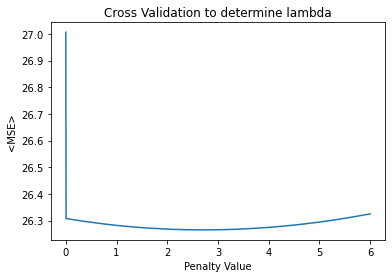

In [13]:
plot_ridge_cv, trial_penalties, opt_lambda = cv_ridge(X_train_r, y_train_r, 5, folds_r)

We see our optimal penalty value is 2.637: the graph highlights this. Now we can retrain the model using this optimal value and produce the in and out of sample MSE.

The plot above, and the method we used to find the optimal penalty value overall, is exactly how we compute it per fold too.

### Question 1.2.2

In [14]:
model_RR = model_ridge_regression(X_train_r, y_train_r, opt_lambda, X_test_r, y_test_r)

print('MSE using the optimal lambda on the training set is {}'.format(model_RR["mse_train"]))
print('----------')
print('MSE using the optimal lambda on the test set is {}'.format(model_RR["mse_test"]))

MSE using the optimal lambda on the training set is 24.577
----------
MSE using the optimal lambda on the test set is 19.374


Interestingly we see only very slight deviation in the MSE obtained on the training and test data compared with linear regression. We see an increase of circa 0.2 within the training set and a decrease of 0.2 in the testing set. This very slight change does indicate that the ridge regression is performing better on 'unseen' data compared with linear regression.

Let's print the new beta parameter to compare with the previous

In [15]:
print(model_RR["beta_val"])

[22.38131385 -0.6348782   0.56825715 -0.10190739 -0.10159593 -0.83163433
  1.58624491 -0.15822652 -1.72027923  1.5739793  -0.1000781  -0.87236869
  0.82178793 -3.60485148 -0.83163433 -0.8720808   0.56828107 -1.7211021 ]


These beta parameters are far smaller than those produced by linear regression as we would expect: ridge restricts the beta values. As the beta values are smaller we are less prone to overfitting which explains the better performance on the test set using ridge regression.

## Question 1.3

### Question 1.3.1

We repeat the same task as 1.2.1 but, this time use kNN as the regression model. We'll define a euclidean distance function initially.

In [16]:
def euc_dist(p, q):
    return np.sqrt(np.sum((p-q)**2,axis=1))

The next function computes the indices of the k-nearest neighbours

In [17]:
def k_neighbours(X_train, X_test, k, return_distance=False):
    #initialising values. Using lists and then converting to numpy arrays is more efficient.
    n_neighbours = k
    dist = []
    neigh_ind = []
  
    # compute distance from each point x_text in X_test to all points in X_train
    point_dist = [euc_dist(x_test, X_train) for x_test in X_test]

    # determine which k training points are closest to each test point
    for row in point_dist:
      enum_neigh = enumerate(row)
      sorted_neigh = sorted(enum_neigh, key=lambda x: x[1])[:k]

      ind_list = [tup[0] for tup in sorted_neigh]
      dist_list = [tup[1] for tup in sorted_neigh]

      dist.append(dist_list)
      neigh_ind.append(ind_list)
  
  # return distances together with indices of k nearest neighbouts
    if return_distance:
      return np.array(dist), np.array(neigh_ind)
  # else return the indices
    return np.array(neigh_ind)

Next we define a useful prediction function for the kNN algorithm.

In [18]:
def kNN_reg_predict(X_train, X_test, y_train, k):
  # compute the indices of the k nearest neighbours
  neighbours = k_neighbours(X_train, X_test, k)
  # the y prediction is computed using the mean of y_train values at the indices generated from the previous function.
  y_pred = np.array([np.mean(y_train[neighbour]) for neighbour in neighbours])

  return y_pred

Now, a model function which trains and makes a prediction, then returns both the train mse and test data mse. We create this function for later use, when we compare the mse between the train and test data.

In [19]:
def model_kNN_reg(X_train, y_train, X_test, y_test, k):
    # train the model and predict on the train data
    y_pred_train = kNN_reg_predict(X_train, X_train, y_train, k)
    # train the model and predict on the test data
    y_pred_test = kNN_reg_predict(X_train, X_test, y_train, k)
    y_true_train = y_train
    y_true_test = y_test
    
    # compute mse for train mse and test mse 
    mse_train = round(np.square(np.subtract(y_pred_train, y_true_train)).mean(), 3)
    mse_test = round(np.square(np.subtract(y_pred_test, y_true_test)).mean(), 3)
    return mse_train, mse_test

The next function performs the cross validation, using the 5 folds we created earlier. It produces a plot of the MSE for each penalty value on each fold (grey). In addition, there is a plot of the average MSE across the folds for each penalty value (red). It prints the minimal MSE and correspoding k-value for each fold too.

Once again, I chose the range of k values as the plot demonstrates a concave shape so we know the optimal value lies somewhere in this region.

In [20]:
def cv_kNN(X, y, num_folds, folds):
    trial_k = range(1,10)
    M = np.zeros([num_folds, len(trial_k)])

    for i, j in enumerate(folds):
        # define the training set
        idx = list(range(0,i)) + list(range(i+1, num_folds))
        training_set = np.concatenate([folds[p] for p in idx])
        X_train = training_set[:,:-1]
        y_train = training_set[:, -1]
    
        # define the validation set
        cv_set = folds[i]
        X_cv = cv_set[:,:-1]
        y_cv = cv_set[:,-1]

        for k in trial_k:
            # train the model
            y_pred = kNN_reg_predict(X_train, X_cv, y_train, k)
            y_true = y_cv
            M[i,k-1] = np.square(np.subtract(y_pred, y_true)).mean()


        # same format as the previous cross validation
        mini = min(M[i,:])
        temp_opt_k = trial_k[np.argmin(M[i,:])]
        print('fold {}, minimal mse is {}, corresponding k value is {}'.format(i+1, round(mini,3), round(temp_opt_k,3)))
        print('----------')
    
    avg_mse = np.mean(M, axis=0)
    min_avg_mse = min(avg_mse)
    opt_k = trial_k[np.argmin(avg_mse)]
    
    print('Optimal K is {} and the <MSE> at that point is {}'.format(round(opt_k,3), round(min_avg_mse,3)))
    print('----------')

    #Plots of k against mse, for each folds and the average of these in red
    [plt.plot(trial_k, M[i,:], color='gray', linewidth=0.5) for i in range(5)]
    plt.plot(trial_k, avg_mse, color='r', linewidth=1, label='Average Across the Folds')
    plt.legend()
    plt.xlabel('Penalty Value')
    plt.ylabel('MSE')
    plt.title('Cross Validation to determine K')

    return plt, avg_mse, opt_k, M

fold 1, minimal mse is 8.752, corresponding k value is 3
----------
fold 2, minimal mse is 9.476, corresponding k value is 1
----------
fold 3, minimal mse is 21.869, corresponding k value is 1
----------
fold 4, minimal mse is 13.318, corresponding k value is 3
----------
fold 5, minimal mse is 13.22, corresponding k value is 2
----------
Optimal K is 3 and the <MSE> at that point is 14.745
----------


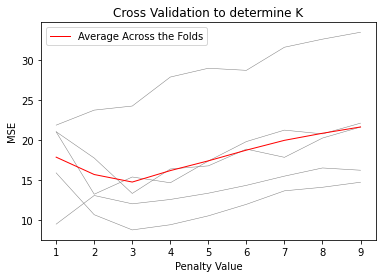

In [21]:
plot_kNN_cv, avg_mse_kNN, opt_k, M_kNN = cv_kNN(X_train_r, y_train_r, 5, folds_r)

We calculate the optimal k value by finding the value which gives the smallest average MSE across the folds: the k value corresponding to the lowest point on the the red curve. This value is k=3. The question specifies that we demonstrate on one fold, but I think displaying the plots for each fold and the average presents the information more clearly. We can see the optimal value for each fold clearly and the optimal value. However, for the purpose of 1.3.1 (ii) we will consider the plot for fold 1 (see below).

The function beneath produces the MSE plot for all k-values on Fold 1. It returns a list containing these MSE values and a numpy array. The first row of the array contains the mean of the residuals at each k value, the second row contains the standard deviation of the residuals at each k value.

In [22]:
def compute_errors(X, y, folds):
    # generate k values
    trial_k = range(1,10)
    # list to store MSEs
    f1_mse = []
    # error matrix
    f1_errors = np.zeros([2, 9])
    # first set of training and test data
    idx = list(range(0,0)) + list(range(0+1, 5))
    training_set = np.concatenate([folds[p] for p in idx])
    X_train = training_set[:,:-1]
    y_train = training_set[:, -1]
    
    # define the validation set
    cv_set = folds[0]
    X_cv = cv_set[:,:-1]
    y_cv = cv_set[:,-1]
    for k in trial_k:
        # train the model
        y_pred = kNN_reg_predict(X_train, X_cv, y_train, k)
        y_true = y_cv
        f1_mse.append(np.square(np.subtract(y_pred, y_true)).mean())
        # calculate the residual
        res = y_pred - y_true
        # compute mean and std
        mu, std = np.mean(res), np.std(res)
        f1_errors[0,k-1] = mu
        f1_errors[1,k-1] = std
    # produce the plots
    plt.plot(trial_k, f1_mse, color='blue', linewidth=1)
    plt.xlabel('Penalty Value')
    plt.ylabel('MSE')
    plt.title('MSE Across Fold 1')

    return f1_errors, f1_mse
    

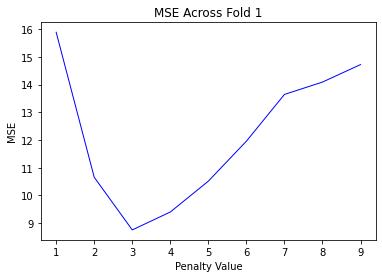

In [23]:
f1_errors, f1_mse = compute_errors(X_train_r, y_train_r, folds_r)

In [24]:
print('Fold 1 Errors: \n {}'.format(f1_errors))
print('Fold 1 MSE: \n {}'.format(f1_mse))

Fold 1 Errors: 
 [[ 0.17283951  0.00802469 -0.15473251 -0.1632716  -0.12444444 -0.14567901
  -0.19153439 -0.27546296 -0.35034294]
 [ 3.98264793  3.26419461  2.95439181  3.06142388  3.2400945   3.45478712
   3.6890226   3.74379654  3.82108601]]
Fold 1 MSE: 
 [15.891358024691359, 10.655030864197533, 8.752373113854595, 9.398973765432096, 10.513698765432094, 11.95677640603566, 13.645573192239858, 14.09189236111111, 14.723438500228628]


These results demonstrate that the algorithm is performing very well. We see the mean of the residuals are very close to zero for all penalty value, the standard deviation is smallest for k=3. This explains why we see the minima at 3.

Now let's train the data using this optimal parameter and compare the in and out of sample MSE.


In [25]:
train_mse_kNN, test_mse_kNN = model_kNN_reg(X_train_r, y_train_r, X_test_r, y_test_r, 3)
print('In sample MSE = {}'.format(train_mse_kNN))
print('----------')
print('Out of sample MSE = {}'.format(test_mse_kNN))

In sample MSE = 5.093
----------
Out of sample MSE = 12.477


In comparison to the two previous regression models we see vastly reduced in sample and out of sample MSEs. We do have some overfitting as the in sample MSE is only 5 in comparison to the out of sample MSE at 12.477. 

As the linear and ridge regression models performed worse than kNN we expect that the data is not homogenous and non-linear.

Note: I chose not to standardise the data for two reasons. If we standardise the data I believe making comparisons to linear and ridge regression are less apt. In addition, we see a very low in sample and out of sample mse regardless.

## Task 2: Classification

Firstly, let's read in the data and convert it to numpy arrays.

In [26]:
# read in data
df_classification_train = pd.read_csv('classification_train.csv', header=None)
df_classification_test = pd.read_csv('classification_test.csv', header=None)

In [27]:
# create the train and test data from the file, this time we'll keep them as pandas data frames

X_train_c = df_classification_train[df_classification_train.columns[:-1]]
X_test_c = df_classification_test[df_classification_test.columns[:-1]]
y_train_c = df_classification_train[df_classification_train.columns[-1]]
y_test_c = df_classification_test[df_classification_test.columns[-1]]

# convert to np arrays

X_train_c = np.array(X_train_c)
X_test_c = np.array(X_test_c)
y_train_c = np.array(y_train_c)
y_test_c = np.array(y_test_c)

## Question 2.1

### Question 2.1.1

For this question, we must construct a logistic regression classifier using gradient descent, then use 5-fold cross validation to determine the optimal hyperparamter values for the learning rate and decision threshold.

To begin with, we construct the logistic function.

In [28]:
def logistic(x):
    return 1/(1 + np.exp(-x))

For ease of notation later on, we define a function which returns $$ y_{log} = logistic(\beta^{T} X + \beta_{0}). $$ In addition to this, we also need to initialise our beta parameters. We can either set them to be zero of randomly assign values to them. I chose to make them zero.

In [29]:
def y_pred_log(X, beta, beta0):
    y_log = logistic(beta.T @ X + beta0)
    return y_log

def initialise(d):
    # initialise beta 
    beta = np.zeros([d,1], dtype=np.float32)
    beta0 = 0

    # check shapes and type of variables
    assert(beta.shape==(d,1))
    assert(isinstance(beta0, float) or isinstance(beta0, int))

    return beta, beta0

The next function propagate, implements the 'forward pass' procedure. It calculates the gradients of our cost function relative to $\beta$ and $\beta_{0}$.

In [30]:
def propagate(X, y, beta, beta0):

    n = X.shape[1]
    y_log = y_pred_log(X, beta, beta0)

    # cost function
    cost = (-1) * np.mean(np.multiply(y, np.log(y_log)) + np.multiply(1-y, np.log(1 - y_log)), axis=1)

    # derivatives
    dbeta = 1/n * X@(y_log - y).T
    dbeta0 =  np.mean((y_log - y))

    # checking size and type of variables
    assert(dbeta.shape==beta.shape)
    assert(dbeta0.dtype==float)
    cost = np.squeeze(cost)
    assert(cost.shape==())
  
    # store gradients in a dictionary
    grads = {"dbeta": dbeta, "dbeta0": dbeta0}
  
    return grads, cost

The optimise function below, constructs the final parameters $\beta$ and $\beta_{0}$ as well as the gradients.

In [31]:
def optimise(X, y, beta, beta0, num_iterations=5000, learning_rate=0.5, print_cost=False):

  # initialise costs
  costs = []
    
  for i in range(num_iterations):

      alpha = learning_rate

      # calculate cost and gradients
      grads, cost = propagate(X, y, beta, beta0)
      
      # retrieve derivatives from grads
      dbeta = grads["dbeta"]
      dbeta0 = grads["dbeta0"]
      
      # updating procedure
      beta -= alpha*dbeta
      beta0 -= alpha*dbeta0
      
      # record the costs
      if i % 100 == 0:
          costs.append(cost)
      
      # print the cost every 100 iterations
      if print_cost and i % 100 == 0:
          print ("cost after iteration %i: %f" %(i, cost))
  
  # save parameters and gradients in dictionary
  params = {"beta": beta, "beta0": beta0}
  grads = {"dbeta": dbeta, "dbeta0": dbeta0}
  
  return params, grads, costs

The function below, produces the binary predictions for the labels in our 'test set', whatever we choose that to be.

In [32]:
def log_pred(X_test, beta, beta0, decision_threshold=0.5):
 
  n = X_test.shape[1]
  y_pred = np.zeros((1,n))
  beta = beta.reshape(X_test.shape[0], 1)
  
  # compute vector y_log predicting the probabilities
  y_log = y_pred_log(X_test, beta, beta0)
  
  for i in range(y_log.shape[1]):
      
      # convert probabilities y_log to actual predictions y_pred
      if y_log[0, i] > decision_threshold:
          y_pred[0, i] = 1 
      else:
          y_pred[0, i] = 0
  
  assert(y_pred.shape==(1, n))
  
  return y_pred

Now, we can combine all previous function into a modelling function to easily implement the procedure using different parameters and compare results.

In [33]:
def model_classification_logistic(X_train, y_train, X_test, y_test, num_iterations=5000, learning_rate=0.5, decision_threshold=0.5, print_cost=False):
  # tranpose X matrices
  X_train = X_train.T
  X_test = X_test.T
  
  # initialize parameters with zeros
  beta, beta0 = initialise(X_train.shape[0])

  # gradient descent
  parameters, grads, costs = optimise(X_train, y_train, beta, beta0, num_iterations, learning_rate, print_cost=print_cost)

  # retrieve parameters beta and beta_0 from dictionary "parameters"
  beta = parameters["beta"]
  beta0 = parameters["beta0"]

  # predict test and train set examples
  y_pred_test = log_pred(X_test, beta, beta0, decision_threshold)
  y_pred_train = log_pred(X_train, beta, beta0, decision_threshold)

  # print train/test Errors
  train_acc = 100 - np.mean(np.abs(y_pred_train - y_train)) * 100
  test_acc = 100 - np.mean(np.abs(y_pred_test - y_test)) * 100
  # saving all information
  d = {"costs": costs, "test_accuracy": test_acc, "train_accuracy": train_acc, "y_pred_test": y_pred_test, "y_pred_train": y_pred_train, "beta": beta, "beta0": beta0, "learning_rate": learning_rate, "num_iterations": num_iterations}
  
  return d

As before, we perform cross validation. In this instance we are optimising two values instead of one; as such, we use a grid-search to find the best combination of parameters. This involves iterating through each possible combination of parameters and storing the MSE values for each case in a matrix. The function prints the optimal combination at each fold, the corresponding MSE and also a contour plot of the matrix which stores the MSE values.

In [34]:
def cv_logistic(X, y, num_folds, folds, num_iterations=5000):
    decision_thresholds = np.arange(0, 1, 0.1)
    learning_rates = np.arange(0.2,1.2,0.2)

    for i, j in enumerate(folds):
        opt = {"Fold": i+1, "Highest Accuracy": 0, "Learning Rate": 0, "Decision Threshold": 0}
        idx = list(range(0,i)) + list(range(i+1, num_folds))
        training_set = np.concatenate([folds[p] for p in idx])
        X_train = training_set[:,:-1]
        y_train = training_set[:, -1]
    
        # define the validation set
        cv_set = folds[i]
        X_cv = cv_set[:,:-1]
        y_cv = cv_set[:,-1]

        # Matrix to store MSE values per fold
        M = np.zeros([len(learning_rates), len(decision_thresholds)])

        # grid search
        for m in range(len(learning_rates)):
            for n in range(len(decision_thresholds)):
                d = model_classification_logistic(X_train, y_train, X_cv, y_cv, learning_rate=learning_rates[m], decision_threshold=decision_thresholds[n])
                M[m,n] = d["test_accuracy"]

        # find optimal values per fold
        max_acc = np.amax(M)
        idx_max = np.unravel_index(M.argmax(), M.shape)
        LR = learning_rates[idx_max[0]]
        DT = decision_thresholds[idx_max[1]]
        print('Max Accuracy on fold {} is {}%, when the learning rate is {} and the decision threshold is {}'.format(i+1, max_acc, LR, DT))
        print('----------')

        # produce the plots
        df = pd.DataFrame(data=M, index=learning_rates, columns=decision_thresholds)
        X = df.columns.values
        Y = df.index.values
        Z = df.values
        x, y= np.meshgrid(X, Y)
        plt.contourf(x, y, Z, cmap='flare', levels=100)
        plt.colorbar()
        plt.title('Heat Map of Test Accuracy on fold {}'.format(i+1))
        plt.xlabel('Decision Threshold')
        plt.ylabel('Learning Rate')
        plt.show()
        plt.close()
        print('----------')
    
    
    return



We need to create a new set of folds using the classification data set.

In [35]:
np.random.seed(1)
folds_c = tfold_split(X_train_c, y_train_c, 5) # compute folds

Let's run the cross validation

Max Accuracy on fold 1 is 73.125%, when the learning rate is 0.2 and the decision threshold is 0.6000000000000001
----------


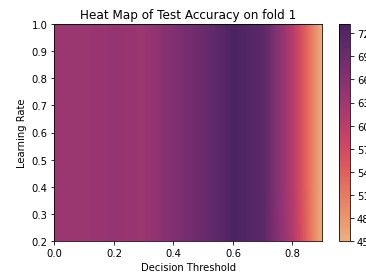

----------
Max Accuracy on fold 2 is 73.125%, when the learning rate is 0.2 and the decision threshold is 0.5
----------


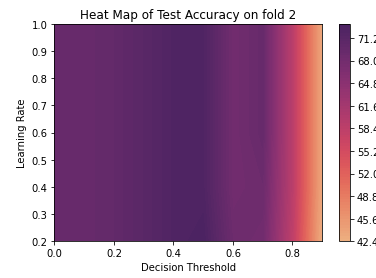

----------
Max Accuracy on fold 3 is 74.375%, when the learning rate is 0.2 and the decision threshold is 0.5
----------


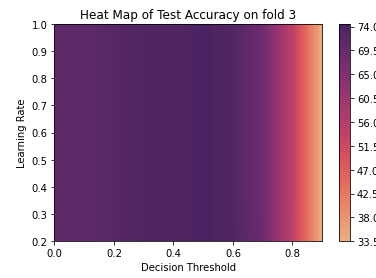

----------
Max Accuracy on fold 4 is 77.5%, when the learning rate is 0.2 and the decision threshold is 0.4
----------


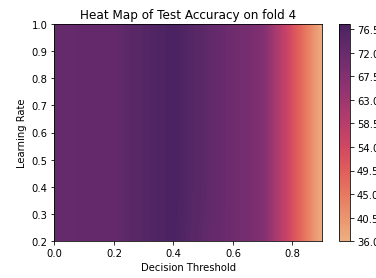

----------
Max Accuracy on fold 5 is 76.875%, when the learning rate is 0.2 and the decision threshold is 0.4
----------


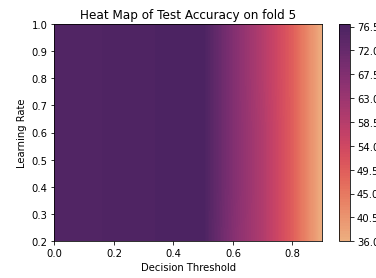

----------


In [36]:
cv_logistic(X_train_c, y_train_c, 5, folds_c)

Interestingly we see the learning rate of 0.2 is optimal for all our folds, we have a range of decision thresholds from 0.4 to 0.6. We will set our optimal learning rate parameter to 0.2. For the decision threshold, we take the mean over the 5 folds as they are all very similar: this gives 0.48 which we'll round to 0.5. Now let's use these optimal parameters to compute the in and out of sample accuracy.

In [37]:
LR = 0.2
DT = 0.5
d_log = model_classification_logistic(X_train_c, y_train_c, X_test_c, y_test_c, learning_rate=LR, decision_threshold=DT)

print('Training Accuracy is {}%'.format(d_log["train_accuracy"]))
print('----------')
print('Test Accuracy is {}%'.format(d_log["test_accuracy"]))

Training Accuracy is 74.375%
----------
Test Accuracy is 74.0%


Using our optimal model we get a training accuracy of 74.375% and a test accuracy of 74%. This is not extremely high - most likely due to a large number of features, some of which may be correlated. However, our model does not appear to be overfitting as the in sample and out of sample accuracies are very similar.

## Question 2.2

### Question 2.2.1

For the next part of the coursework I am implementing a random forest classifier which uses cross-entropy to determine the splits in the decision trees. Firstly, let's define a function to determine the cross entropy, namely CE and also a function to calcualte the information gain: this is used when determining optimal splits. The cross entropy I used is the one defined in 'Elements of Statistical Learning' as the one given in lectures was undefined if p=1.

In [38]:
def CE(y):

    num_labels = y.shape[0]
    # case for low dimension y
    if num_labels <= 1:
        return 0

    # creates to arrays containing the values of y, and how many times they appear
    value, counts = np.unique(y, return_counts=True)
    # calculation of \pi(R_{\alpha})
    probs = counts / num_labels
    num_classes = np.count_nonzero(probs)

    # case if all the probabilities are zero
    if num_classes <= 1:
        return 0
    # initialise entropy value
    entropy = 0

    # compute the entropy
    for p in probs:
        entropy -= p*np.log(p)

    return entropy

# compute the information gain, after making a split
def information_gain(y, y1, y0):
    IG = CE(y) - (CE(y1)*y1.shape[0] + CE(y0)*y0.shape[0])/y.shape[0]
    return IG

At this point I made the decision to construct this algorithm in a different way to the previous ones. I chose to build 'decisiontree', 'Node' and 'randomforest' objects using a class structure. I felt as though the code could be more streamlined, easier to read and personally made more sense for me. Comparatively, the previous algorithms: kNN, regression etc. are much simpler and do not require as many functions and constructions so there was no need to use this structure with them. If I were creating a machine-learning package I would convert them to classes but, for the purposes of this coursework it made very little difference.

As the decision tree algorithm is significantly more complex than the previous ones, I have very thoroughly commented the code so it is as readable as possible.

Firstly, we define two functions split and best_split.

In [39]:
# function which splits X and y based on the threshold
def split(X, y, feature_idx, threshold):
    # initialise as lists then convert to np arrays for efficiency
    X1, y1, X0, y0 = [], [], [], []
    # iterate through X and y, grouping values which satisfy and don't satisfy the condition
    for j in range(len(y)):
        if X[j][feature_idx] <= threshold:
            X1.append(X[j])
            y1.append(y[j])
        else:
            X0.append(X[j])
            y0.append(y[j])

    # convert to np arrays
    X1 = np.array(X1)
    y1 = np.array(y1)
    X0 = np.array(X0)
    y0 = np.array(y0)

    return X1, y1, X0, y0

# defines the best split at a node
def best_split(X, y, rs_idx):
    # initialising values
    num_features = X.shape[1]
    best_gain_cost = 0
    best_feature_idx = 0
    best_threshold = 0

    # iterate through the index of the random sample of features we choose, calculating the threshold and subsequent information gain
    for feature_idx in rs_idx:
        unique_vals = sorted(set(X[:, feature_idx]))

        for j in range(len(unique_vals) - 1):
            threshold = (unique_vals[j] + unique_vals[j+1])/2
            X1, y1, X0, y0 = split(X, y, feature_idx, threshold)
            info_gain_cost = information_gain(y, y1, y0)

            # update values if the new cost is the best so far
            if info_gain_cost > best_gain_cost:
                best_gain_cost = info_gain_cost
                best_feature_idx = feature_idx
                best_threshold = threshold

    return best_feature_idx, best_threshold

I felt as though defining the Nodes, then the trees, then the forests had a nice flow. So, below we have the Node implementation.

In [40]:
class Node(object):
    # initialise the object
    def __init__(self, feature_idx, threshold, branch1, branch0):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.branch1 = branch1
        self.branch0 = branch0

Then, the decision tree.

In [41]:
class decisiontree(object):
    # initialise the attributes of the decision tree class
    # num_predictors defines the number of predictors used at each split
    # maximum depth of the tree
    # minimum samples needed at a given node, to determine a new split, almost always I will set this to 1
    def __init__(self, num_predictors, max_depth,
                    min_samples_leaf):
        self.num_predictors = num_predictors
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf


    # function which builds the tree recursively, very similar to that in the CT
    def build_tree(self, X, y, rs_idx, depth):
        
        # clause for no features, or depth is too great, or X is too small, or cross entropy is zero, or all labels are the same
        if len(rs_idx)==0 or depth >= self.max_depth or len(X) < self.min_samples_leaf or CE(y) == 0 or len(np.unique(y))==1:
            return mode(y)[0][0]

        # compute the best split
        feature_idx, threshold = best_split(X, y, rs_idx)

        # split the data and added clause for zero dimensional y
        X1, y1, X0, y0 = split(X, y, feature_idx, threshold)
        if y1.shape[0] == 0 or y0.shape[0] == 0:
            return mode(y)[0][0]
        
        # create the branches recursively
        branch1 = self.build_tree(X1, y1, rs_idx, depth+1)
        branch0 = self.build_tree(X0, y0, rs_idx, depth+1)

        return Node(feature_idx, threshold, branch1, branch0)

    # train function which constructs the tree
    def train(self, X, y):

        num_features = X.shape[1]
        # governs number of predictors considered at each split
        num_sub_features = int(self.num_predictors(num_features))
        # index of the random sample of features we select
        rs_idx = random.sample(range(num_features), num_sub_features)
        
        self.treebuild = self.build_tree(X, y, rs_idx, 0)

    # function which predicts of each instance in X
    def predict(self, X):
        # initialisation
        num_samples = X.shape[0]
        class_pred = np.zeros(num_samples)
        # iterate through the samples, constructing a node and checking if our features satisfy the threshold condition
        for j in range(num_samples):
            node = self.treebuild

            while isinstance(node, Node):
                if X[j][node.feature_idx] <= node.threshold:
                    node = node.branch1
                else:
                    node = node.branch0
            class_pred[j] = node

        return class_pred

Now, we have built up the decision tree object and the nodes, we can construct the random forest object

In [42]:
class randomforest(object):
    # initialise the attributes of the class
    # same as before apart from num_trees= number of trees in the forest
    # bootstrap, a variable in (0,1) from which we consider (number of samples)*(boostrap value) within our tree - this helps reduce overfitting
    def __init__(self, num_trees, num_predictors, max_depth,
        min_samples_leaf, bootstrap):

        self.num_trees = num_trees
        self.num_predictors = num_predictors
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.bootstrap = bootstrap
        self.forest = []

    # training function for the forest
    def train(self, X, y):
        # initialising variables and creating the number of sub samples as mentioned
        self.forest = []
        num_samples = X.shape[0]
        num_sub_samples = int(round(num_samples*self.bootstrap))
        
        # iterate through the number of trees, each time building a tree and appending this to the forest for which we will later use to predict
        for i in range(self.num_trees):
            # generate reduced X_train and y_train
            X_subset = X[:num_sub_samples]
            y_subset = y[:num_sub_samples]

            # build the tree, calling the decisiontree object
            tree = decisiontree(self.num_predictors, self.max_depth, self.min_samples_leaf)
            tree.train(X_subset, y_subset)
            self.forest.append(tree)

    # make predictions from the forest 
    def predict(self, X):
        num_samples = X.shape[0]
        num_trees = self.num_trees
        # prediction matrix to store values
        preds = np.zeros([num_trees, num_samples])
        for i in range(num_trees):
            preds[i,:] = self.forest[i].predict(X)

        return mode(preds)[0][0]

    # score function to determine accuracy or the confusion matrix
    def score(self, X_test, y_test, confusion=False):
        # y prediction
        y_pred = self.predict(X_test)
        if confusion==False:
            # accuracy
            return np.float(sum(y_pred==y_test))/float(len(y_test))
        else:
            # confusion matrix
            y_pred = pd.Series(y_pred, name='Predicted')
            y_true = pd.Series(y_test, name='Actual')
            confusion_mat = pd.crosstab(y_true, y_pred)
            return confusion_mat

At this point we can write a concise modelling function which trains the data and makes predictions, returning both the training and testing confusion matrices.

In [66]:
def model_random_forest(X_train, y_train, X_test, y_test, num_trees=5, num_predictors=lambda x: x/3, max_depth=10,
        min_samples_leaf=1, bootstrap=0.4, confusion=True):

    # build the forest
    forest = randomforest(num_trees, num_predictors, max_depth,
        min_samples_leaf, bootstrap)

    # train the data set
    forest.train(X_train, y_train)

    # create the predictions and score
    conmat_train = forest.score(X_train, y_train, confusion)
    conmat_test = forest.score(X_test, y_test, confusion)

    return conmat_train, conmat_test

Once again, we perform cross validation. This time, using the same classification folds as in the logistic regression function. There are three hyperparameters to optimise here so we perform the computationally expensive procedure of iterating through each possible combination. Although, there may be faster ways of optimising certain parameters separately, this method is the most thorough and thus, why I chose it. I trialled some values and chose to fix the bootstrapping value to 0.4 as it is a good balance between speed and accuracy.

The function below implements this cross validation and prints the optimal combination of hyperparameters per fold. (It takes roughly 10-15 mins to run on my PC: AMD 3600X, RTX 2060, 16GB 3200MHz RAM)

In [68]:
def cv_rf(X, y, num_folds, folds):
    # initialise parameters
    max_depths = np.arange(5,25,5)
    tree_range = np.arange(5,45,10)
    preds = np.arange(2, 5)
    
    # iterate through folds
    for i, j in enumerate(folds):
        idx = list(range(0,i)) + list(range(i+1, num_folds))
        training_set = np.concatenate([folds[p] for p in idx])
        X_train = training_set[:,:-1]
        y_train = training_set[:, -1]
        
        # define the validation set
        cv_set = folds[i]
        X_cv = cv_set[:,:-1]
        y_cv = cv_set[:,-1]

        y_cv = np.squeeze(y_cv)
        y_train = np.squeeze(y_train)

        # initialise optimal values for each fold

        max_acc = 0
        MD = 0
        NT = 0
        NP = 0

        # iterate through all combinations
        for m in range(len(max_depths)):
            for n in range(len(tree_range)):
                for o in range(len(preds)):
                    # create the model
                    forest = randomforest(num_trees=tree_range[n], num_predictors=lambda x: x/preds[o], max_depth=max_depths[m], min_samples_leaf=1, bootstrap=0.4)
                    forest.train(X_train, y_train)
                    acc = forest.score(X_cv, y_cv)
                    # update values if necessary
                    if acc > max_acc:
                        max_acc = acc
                        MD = max_depths[m]
                        NT = tree_range[n]
                        NP = preds[o]

       
        # print results
        print('Max Accuracy on fold {} is {}%, when the max depth is {}, the number of trees is {} and the number of predictors at each split is {}'.format(i+1, 100*max_acc, MD, NT, NP))
        print('----------')
    
    return 

In [69]:
df_cv_forest = cv_rf(X_train_c, y_train_c, 5, folds_c)

KeyboardInterrupt: 

Taking averages of the optimal parameters over our folds we have some form of metric to choose the values. We round the results and hence, set the max depth to be 10, the number of trees to be 25 and, the number of predictors at each split to be 2. Now let's compare the performance of this optimal model on the training and test data.

### Question 2.2.2

In [46]:
train_con, test_con = model_random_forest(X_train_c, y_train_c, X_test_c, y_test_c, num_trees=25, num_predictors=lambda x: x/2, max_depth=10, min_samples_leaf=1, bootstrap=0.4, confusion=True)

In [47]:
print('Training Confusion Matrix \n {}'.format(train_con))
print('----------')
print('Test Confusion Matrix \n {}'.format(test_con))

Training Confusion Matrix 
 Predicted  0.0  1.0
Actual             
0.0        118  119
1.0         31  532
----------
Test Confusion Matrix 
 Predicted  0.0  1.0
Actual             
0.0         15   48
1.0          9  128


For the training data we have 

    - TP = 528

    - TN = 114 

    - FP = 123

    - FN = 35
    
    - Accuracy = 80.2% 

    - Precision = 81.1% 

    - Recall = 93.4% 
    
    - F1 = 0.87

For the test data we have

    - TP = 125

    - TN = 17 

    - FP = 46 

    - FN = 12
    
    - Accuracy = 71% 

    - Precision = 73.1% 

    - Recall = 91.2% 
    
    - F1 = 0.81

For both data sets we see high quality results. As we would expect, the training data results are consistently higher across all factors. Overfitting is one of the main problems associated with random forest classifiers and so, despite adding in additional features to combat this - such as bootstrapping and bagging - it has still occured. Most likely performing a very detailed cross validation with thousands of trial values for all parameters would lead to the most optimal selection of parameters: this could be implemented with more computing power. I believe the overfitting has occured from the selection of the 'optimal parameters'; there is a wide spread of results from the cross validation and the metric used to create the optimal set is variable.

## Question 2.3

### Question 2.3.1

The final question focuses on SVMs. Firstly, we'll implement the linear SVM using stochastic gradient descent. We'll assume a 1 has been added to the end of each row of X for this implementation.

In [48]:
# function which returns the weight vector
def svm_sgd(X, y, learning_rate=0.01, num_iterations=1000):
    # initialisations
    m, n = X.shape
    w = np.zeros(n)
    # convert y
    y = np.where(y<=0, -1, 1)
    for i in range(1,num_iterations):
        reg = 1/i # reduces each iteration
        for j in range(1, m):
            # check if condition is satisfied
            if y[j] * (np.dot(X[j], w)) >= 1:
                # alter w
                w -=  learning_rate * (2*reg*w)
            else:
                # alter w
                w += learning_rate * ((y[j]*X[j]) - (2*reg*w))
            
    return w


Score function which makes the predictions and returns the confusion matrix of the implementation.

In [49]:
def score_SVM_linear(w, X, y):
  # convert y into the appropriate format
  y = np.where(y<=0, -1, 1) 
  # computes y prediction
  y_preds = np.sign(np.dot(X, w)) 

  # confusion matrix
  y_pred = pd.Series(y_preds, name='Predicted')
  y_true = pd.Series(y, name='Actual')
  con_mat = pd.crosstab(y_true, y_pred)
  return con_mat

Implementation of the model which returs the w vector and the confusion matrix.

In [50]:
def model_svm_linear(X_train, y_train, X_test, y_test, learning_rate=0.2, num_iterations=1000):
    
    # generate weights
    w = svm_sgd(X_train, y_train, learning_rate, num_iterations)

    # produce the confusion matrix
    con_mat = score_SVM_linear(w, X_test, y_test)

    return w, con_mat


For the next part we need to create a kernelised SVM utilising the RBF kernel. Firstly, we'll need to create the kernel function. $$ rbf(x, y, \gamma) = exp(-\gamma \|x-y\|^{2})$$

In [51]:
def rbf(x, y, gamma):
    res = np.exp(-gamma*(np.linalg.norm(x-y)**2))
    return res

Also, we need the derivative RBF function for use in the w update aspect of the function.

In [52]:
def d_rbf(x, y, gamma):
    dK = -2 * gamma * rbf(x, y, gamma) * (x-y)
    return dK

Next, we implement stochastic gradient descent for the kernel version, this implementation requires our shift, b, to be separate so no ones need to be added to X. This means we also need to update b during the iterations. We return w. This algorithm is like the previous one but, we replace all dot products which the kernel function.

In [53]:
def svm_sgd_rbf(X, y, gamma=0.5, learning_rate=0.01, num_iterations=1000):
    # initialisations
    m, n = X.shape
    w = np.zeros(n)
    b = 0
    # convert the format of y
    y = np.where(y<=0, -1, 1)
    for i in range(1,num_iterations):
        reg = 1/i
        for j in range(1, m):
            # same as previous replacing dot, with rbf
            if (y[j]*(rbf(w, X[j], gamma) + b)) >= 1:
                w -=  learning_rate * (2*reg*w)
            else:
                w += learning_rate * (y[j]*d_rbf(w, X[j], gamma) - (2*reg*w))
                # this time we have to update b too
                b += learning_rate * y[j]
                
                

    return w, b


Same as before, we create a score function this time altering the prediction to accomodate the kernel implementation, returning the confusion matrix.

In [54]:
def score_SVM_rbf(w, X, y, gamma, b):
  # convert y
  y = np.where(y<=0, -1, 1)
  # initialise y predictions
  y_preds = []
  for i in range(X.shape[0]):
    y_pred = np.sign(rbf(w, X[i], gamma) + b)
    y_preds.append(y_pred)
  
  # confusion matrix
  y_pred = pd.Series(y_preds, name='Predicted')
  y_true = pd.Series(y, name='Actual')
  con_mat = pd.crosstab(y_true, y_pred)
  return con_mat

Model function as before.

In [55]:
def model_svm_rbf(X_train, y_train, X_test, y_test, gamma=0.5, learning_rate=0.2, num_iterations=1000):

    # train model
    w, b = svm_sgd_rbf(X_train, y_train, gamma, learning_rate, num_iterations)

    # make predictions and compute confusion matrix
    con_mat = score_SVM_rbf(w, X_test, y_test, gamma, b)

    return w, b, con_mat

Now, we need to perform CV to optimise the gamma paramter of the kernel version of SVM. Unfortuntely, there is a problem with my code such that it predicts 1s for no matter the input. As such, cross validation is futile.

Nevertheless, we can observe the ouputs of the implementations. First though, we must add 1s to the X data set.

In [56]:
# create vector of 1s
m1 = X_train_c.shape[0]
m2 = X_test_c.shape[0]

ones1 = np.ones([m1, 1])
ones2 = np.ones([m2, 1])
# append vectors to the train and test data
X_train_mod = np.concatenate([X_train_c, ones1], axis=1)
X_test_mod = np.concatenate([X_test_c, ones2], axis=1)

In [57]:
# implement
w_l, con_mat_l = model_svm_linear(X_train_mod, y_train_c, X_test_mod, y_test_c)
w_k, b_k, con_mat_k = model_svm_rbf(X_train_mod, y_train_c, X_test_mod, y_test_c)

In [58]:
print('Confusion Matrix for Linear: \n {}'.format(con_mat_l))
print('Confusion Matrix for Kernel: \n {}'.format(con_mat_k))

Confusion Matrix for Linear: 
 Predicted  -1.0   1.0
Actual               
-1           21    42
 1            8   129
Confusion Matrix for Kernel: 
 Predicted  1.0
Actual        
-1          63
 1         137


For Linear SVM we have 

    - TP = 129 

    - TN = 21 

    - FP = 42 

    - FN = 8 
    
    - Accuracy = 75% 

    - Precision = 75.4% 

    - Recall =  94% 
    
    - F1 = 0.84

For Kernel SVM we have

    - TP = 137

    - TN = 0 

    - FP = 63 

    - FN = 0 
    
    - Accuracy = 68.5% 

    - Precision = 68.5% 

    - Recall =  100% 
    
    - F1 = 0.81



Somewhat ironically, we have ended up with not terrible accuracy and precision, perfect recall and a good F1 score for the faulty Kernel SVM Implementation. Ignoring this, we can stil take the positives from the Linear SVM which has a very high Recall and F1 score! As well as, a good accuracy and precision, especially if we compare it to the random forest classifier.

### Question 2.3.2

Implementing this part will show no real results as the kernel implementation is faulty. However, to demonstrate my conceptual understanding I will still discuss the ROC curve. 

The ROC Curve plots False Positive Rate against Recall, but here Recall is always 1 and the False Positive rate is also, always 1. So my ROC curve is just a point at 1. Note, there is also no comparison to be made as the 'optimal' model in my case is no different from any other model.